# HPLC Processing & Analysis

## Overview
**H**igh-**P**erformance **L**iquid **C**hromatography (HPLC) is an analytical technique which allows for the quantitative characterization of the components of a mixture. In the lab, we typically use this this to quantify the turnover of sugars and organic acids such as glucose and acetate. While many of the technical details of HPLC are now automated, the programmatic cleaning and processing of the resulting data can be cumbersome. 


The `cremerlab.hplc` module is written to allevieate some of this burden, making the actual running of the HPLC the most time consuming part of the analysis. The rest of this page will show you how to use the `cremerlab.hplc` module to convert the ASCII data output from our Shimadzu HPLC to a useable format and how to quantify the abundance of the relevant peaks

## Setting Up Your HPLC Run


## ASCII File Conversion
Given a configuration like that shown above, the data will be saved in two formats. The first is a proprietary format (with the extension `.lcd`) but the other is an ASCII text document (with the extension `.txt`). The latter document, will have all of the metadata associated with the HPLC run as well as the underlying chromatogram for each detector. 

The ASCII document is formatted such that its (mostly) human readable, but difficult to read programmatically. Furthermore, the file is named in an unclear way, making it difficult to tell what data corresponds to what sample. Luckily, the `.txt` document will have all of the metadata we need to know to map the file to the sample ID we defined when setting up the HPLC run in the previous section. The first sixty or so lines of a representative `.txt` file is shown below:

```
1: [Header]
2: Application Name,LabSolutions
3: Version,5.97 SP1
4: Data File Name,
5: C:\Users\cremerlab\Desktop\griffin\2021-03-17_REL606_NCM3722_turnover\batch_3172021_004_009.lcd
6: Output Date,3/17/2021
7: Output Time,9:36:36 PM
8: 
9: [File Information]
10: Type,Data File
11: Generated,3/17/2021 8:51:17 PM
12: Generated by,System Administrator
13: Modified,3/17/2021 9:36:36 PM
14: Modified by,System Administrator
15:
16: [Sample Information]
17: Operator Name,System Administrator
18: Acquired,3/17/2021 8:51:35 PM
19: Sample Type,1:Standard
20: Level,4
21: Sample Name,2021-03-17_NCM3722_NC_sample004
22: Sample ID,004
...
55: Dilution Factor,1
56: Vial#,31
57: Injection Volume,20
```

We can see that information about the sample name, acquisition date, sample ID, and vial number is buried in the the metadata. Further down in the file, we have the actual data of the chromatogram, 

```
77: [LC Chromatogram(Detector B-Ch1)]
78: Interval(msec),500
79: # of Points,5401
80: Start Time(min),0.000
81: End Time(min),45.000
82: Intensity Units,mV
83: Intensity Multiplier,0.001
84: R.Time (min),Intensity
85: 0.00000,-5
86: 0.00833,-5
87: 0.01667,0
```

with some more metadata about the detector settings. While we could manually piece together the information for each file, the `cremerlab.hplc` module has this ability built in. We can start by loading in the `cremerlab.hplc` module and defining the path to our target file

In [1]:
# Import the os module to show file directory structures
import os

# Import the cremerlab module
import cremerlab.hplc

# Define the path to the file. 
file ='data/2021-03-17_008.txt'

Above, we specified the relative path of the datafile we wish to convert. Right now, this is the only file in the directory: 

In [2]:
os.listdir('data/')

['out', '2021-03-17_008.txt']

To read in that file, get the metadata, and save the chromatogram, we can call the function `cremerlab.hplc.convert` on this path.

In [3]:
# Convert the file specified by the path
cremerlab.hplc.convert(file)

File(s) successfully converted!


We get a message that the conversion was successful. Now, if we look at that same `data` directory, we see a new subdirectory `out/` along with the original file

In [4]:
os.listdir('data/')

['out', '2021-03-17_008.txt']

In that `out/` subdirectory is the converted file saved as a `.csv`

In [5]:
os.listdir('data/out/')

['2021-03-17_NCM3722_NC_sample004.csv']

This file now has a name that is meaningful. Looking at the file shows that the chromatogram has been parsed into a simple comma separated format and the relevant metadata has been put into a list of comments at the top of the file. 

```
1: #
2: # 2021-03-17_NCM3722_NC_sample004
3: # ------------------------------
4: # Acquired: 3/17/2021 8:51:35 PM
5: # Converted: 16:36 -- 2021-03-25
6: # Vial: 31
7: # Injection Volume: 20 uL
8: # Sample ID: 004
9: #
10: # Detector B
11: # ---------------------
12: # Acquisition Interval: 500 ms
13: # Intensity Units: mV
14: # Intensity Multiplier: 0.001
15: #
16: time_min,intensity_mV,detector
17: 0.0,-5,B
18: 0.008329999999999999,-5,B
```

This shows how the `cremerlab.hplc.convert` can quickly convert the obtuse output from the HPLC software to something that's easy to read programmatically. There are many other arguments you can pass to chnage the detector channel, save directory, file names, etc. The documentation for the function can be accessed as `cremerlab.hplc.convert?`.

In [6]:
cremerlab.hplc.convert?

## Quantifying Peaks
With the file converted, we can now try to quantify the chromatogram. Quantification of the peaks involves

1. Loading the chromatogram
2. Identifying the location of the peaks, both isolate dand overlapping.
3. Inferring the area under the peak and deconvolving overlapping peaks.

We can start with loading the chromatogram as a `cremerlab.hplc.Chromatogram` object. This is a glorified pandas DataFrame on which we can call several quantification and visualization methods. 

To load a chromatogram, we just have to provide the file path to the coverted ASCII file.

In [7]:
file = 'data/out/2021-03-17_NCM3722_NC_sample004.csv'
chrom = cremerlab.hplc.Chromatogram(file)


The chromatogram is now loaded into memory, but typing `chrom` doesn't provide much information

In [8]:
chrom

The variable `chrom` is assigned to a `Chromatogram` object, which by itself is not useful. To explore the chromatogram, we can can call the `show()` method on the chromatogram, which will plot the intensity as a function of time

[<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='time_min', ylabel='intensity_mV'>]

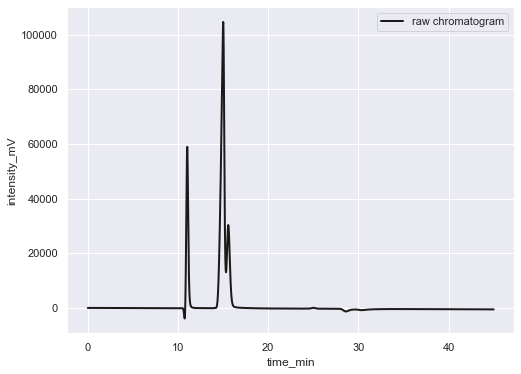

In [9]:
chrom.show()

There appear to be three strong peaks in the chromatogram, but they all occupy a relatively small portion of the actual trace. We can restrict the time range of the chromatogram by the `crop` method on `chrom`. This method takes a single argument of `time_window` which is a list with the lower and upper time bounds we want to consider. Looking at the above plot, we only care about the information between around 10 and 20 minutes.

[<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='time_min', ylabel='intensity_mV'>]

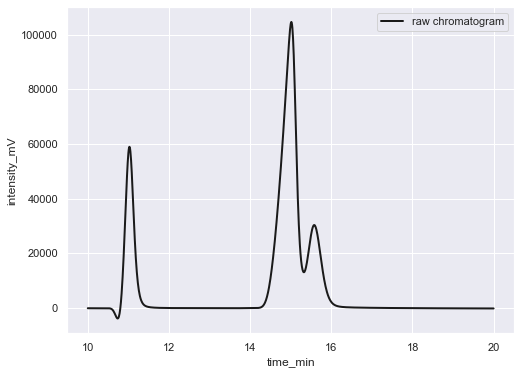

In [10]:
# Crop the chromatogram to consider only a narrow time range
chrom.crop([10, 20])

# Plot the chromatogram again to see the new restricted chromatogram
chrom.show()

Note that after calling the `crop` method, we called the same `show` method that we did earlier. This shows that the chromatogram data in the `chrom` variable how now changed after we called the cropping function.

The three peaks are now clear in the chromatogram, with the latter two overlapping. To properly quantify the area under each peak, we would rather model the overlapping distributions of these peaks rather than drawing a simple threshold at the minimum between them, which is the default integration method in the Shimadzu software. 

The `Chromatogram` object has a method `quantify`, which detects the peaks, breaks the signal down into peak windows, and infers the mixture function. Aside from fitting the peaks, this function also returns a pandas DataFrame with a list of the peaks, their areas, retention time, and various parameters which define the fitting distribution.


In [11]:
# Call the quantification function which returns a peak table.
peak_table = chrom.quantify()

Fitting peak windows...:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting peak windows...:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s]

Fitting peak windows...: 100%|██████████| 2/2 [00:01<00:00,  2.14it/s]

Fitting peak windows...: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

We can show the inferred peak distributions overlaid with the raw chromatogram again by calling the `show` method

[<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='time_min', ylabel='intensity_mV'>]

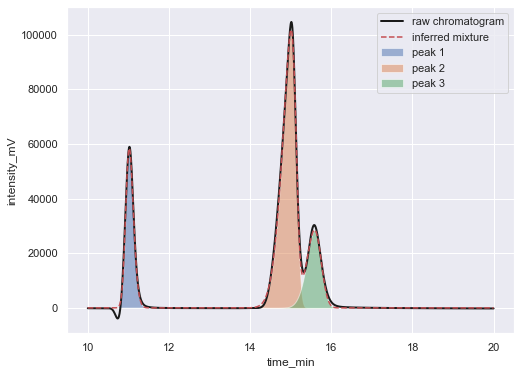

In [12]:
chrom.show()

Here, the raw chromatogram is shown in solid black, the individual peaks are shown in different colors (blue, orange, and green) and the inferred mixture distribution is shown as a dashed red line. **It's important to view this fit for each file you process to make sure that it passes the eye test.**

We can see the quantification by printing the peak table

In [13]:
# Show the quantified peaks
peak_table

,amplitude,area,peak_idx,retention_time,scale,skew
0,14063.714832,1.687646e+06,0,10.951632,0.130844,1.477629
1,42681.637267,5.121699e+06,1,15.135356,0.287974,-3.569331
2,12786.566825,1.534388e+06,2,15.723843,0.251422,-1.644769
